# GOES-16 Notebook

In [1]:
import glob
import sys

import boto3
import botocore
import imageio
import requests
import xarray as xr
from mpl_toolkits.basemap import Basemap, maskoceans
import time
import warnings
import datetime as dt
import os
import fsspec

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as dates
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir
from siphon.http_util import HTTPEndPoint

In [2]:
Socorro_lon, Socorro_lat = -106.9056, 34.0660  # coordinates of NMT measurement site
#Add the following to show arid and semi arid higher elevation areas of the western USA plus some extra on sides as well as CONUS

target = {"ABQ": {"lon": -106.6221, "lat": 35.0376}, # Albuquerque, NM WFO coordinates
          "EPZ": {"lon": -106.6982, "lat": 31.8728}, # Santa Teresa, NM WFO coordinates
          #"MAF": {"lon": -102.11,   "lat": 31.57}, # Midland TX WFO coordinates - below 3000 ft elevation cut off
          "LBB": {"lon": -101.8765,   "lat": 33.5283}, # Lubbock TX WFO coordinates
          "AMA": {"lon": -101.7091,   "lat": 35.2331}, # Amarillo, TX WFO
          "RAP": {"lon": -103.2110,   "lat": 44.0728}, # Rapid City, SD WFO coordinates, listed as UNR in NWS, but in Wyoming as RAP
          #"GGW": {"lon": -106.37,   "lat": 48.13}, #Glagow, MT WFO coordinates - below 3000 ft elevation cut off
          "TFX": {"lon": -111.3822,   "lat": 47.4733}, # Great Falls, MT WFO
          "RIW": {"lon": -108.4778,   "lat": 43.0653}, # Riverton, WY WFO
          "BIL": {"lon": -108.5700,   "lat": 45.7504}, # Billings, MT WFO
          "CYS": {"lon": -104.8057,   "lat": 41.1519}, # Cheyenne, WY WFO
          "PUB": {"lon": -104.5209,   "lat": 38.2797}, # Pueblo, CO WFO
          "DNR": {"lon": -104.9979,   "lat": 39.7455}, # Boulder/Denver WFO coordinates.  Had to change from current BOU to past DNR to work with Wyoming
          "GJT": {"lon": -108.5251,   "lat": 39.1200}, # Grand Junction, CO WFO
          "SLC": {"lon": -111.9552,   "lat": 40.7721}, # Salt Lake City, UT WFO
          "FGZ": {"lon": -111.8384,   "lat": 35.1895}, # Flagstaff, AZ WFO
          "LKN": {"lon": -115.7423,   "lat": 40.8599},  # Elko NV WFO coordinates
          "REV": {"lon": -119.7966,   "lat": 39.5683}  # Reno NV WFO coordinates
          #"TUS": {"lon": -110.56,   "lat": 32.70}  # Tucson AZ WFO coordinates - below 3000 ft elevation cut off
          }

tar_lst = ["ABQ", "EPZ", "AMA", "FGZ", "DNR", "GJT", "SLC", "LKN", "REV", "RAP", "RIW", "TFX"]

#@sriley I moved these here so you can look at the options and change things up here rather than on the plotting function
#@vkelsey OK, thanks
west_tar    = ["ABQ", "EPZ", "LBB", "AMA", "FGZ", "GJT", "SLC", "DNR", "RIW", "RAP", "TFX", "PUB", "CYS", "BIL", "LKN", "REV" ]
nm_tar      = ["ABQ", "EPZ"]
conus_tar   = ["ABQ", "EPZ", "LKN", "DNR", "RAP", "TFX", "REV"]

# @sriley: ortho for Orthographic, merc for Mercator
# @vkelsey:  ortho does a better job of highlighting the angle of incidence and it's effect on readings, but merc is more of what we're accustomed to seeing
map_type = "ortho"

#  It gives a traceback error saying boto3 is not installed but when I go to install it it tells me that it is already there...
s3 = boto3.resource('s3',config=botocore.client.Config(signature_version=botocore.UNSIGNED))
goes = s3.Bucket('noaa-goes16')

In [3]:
fname = "./testing123.tsv"  #you need to delete this file before each new run to keep errors from occuring
elname = "./GMTED2010_15n015_00625deg.nc"  #for elevation map

#### trying to pull from too large of a time period causes a crash
#### may have to stick with 3 month time intervals
## GOES-16 uses UTC time so we have to use that here
## Start date of data pull (YYYY, M, D, H, M, S)
start_date = dt.datetime(2020, 7, 1, 0, 0, 0)
## End date of data pull (YYYY, M, D, H, M, S)
end_date   = dt.datetime(2020, 7, 2, 0, 0, 0)
## Here the freq="12H" lets you pull the data every 12 hours
date_rng = pd.date_range(start=start_date, end=end_date, freq="12H")

## attempts to stop crash from occuring with warnings
with warnings.catch_warnings(record=True):
    warnings.filterwarnings("error")
    try:
        # cool_data = np.loadtxt(fname, dtype=str, delimiter="\t")
        pd_cool = pd.read_csv(fname, sep="\t")
        pd_cool['Date'] = pd.to_datetime(pd_cool['Date'], format="%Y-%m-%d %H:%M:%S")
        last_indx = date_rng.get_loc(pd_cool['Date'][pd_cool.index[-1]] + dt.timedelta(hours=12))
    except (FileNotFoundError, UserWarning):
        last_indx = 0
    except KeyError:
        print("The last date in the file {} is the same as the end date specified above.".format(fname))

#pull data every 12 hrs, 00z and 12z
#date_rng = pd.date_range(start=start_date, end=end_date, freq="12H")
date_rng = date_rng[last_indx:len(date_rng)]

In [4]:
"""""
@title wyoming_import
@brief Imports Wyoming Data for specified site and date
@param end_date
@param station
@return
"""


def wyoming_import(end_date, station):
    try:
        df_00 = WyomingUpperAir.request_data(end_date, station)
        if df_00.pw[0] < 100:
            pw00 = df_00.pw[0]
        else:
            pw00 = np.nan
    except (ValueError, IndexError):
        pw00 = np.nan
    except requests.exceptions.HTTPError:
        print("HTTPError: 10 seconds to restart")
        time.sleep(10)
        pw00 = wyoming_import(end_date, station)
    return pw00


def xarray_haversine_index2d(lon_dat, lat_dat, lon0, lat0):
    '''
    function calculates nearest j-i index to lat-lon pair within a xarray.dataarray
    '''

    # input:
    #
    # xr_dataarray : xarray.DataArray whose parent
    #   xarray.DataSet to which
    #   metpy.xarray.MetPyDataArrayAccessor.parse_cf() and
    #   metpy.xarray.MetPyDataArrayAccessor.assign_latitude_longitude()
    #   has been applied
    #
    # lon0 : Target Longitude
    #   Must be a scalar floating point
    #   (units presumed to be in degrees_east)
    #
    # lat0 : Target Latitude.
    #   Must be a scalar floating point
    #   (units presumed to be degrees_north)

    # return output:
    #   xarray_haversine_index2d() : J and I of
    #   values in xr_dataarray that are the
    #   closest in surface sphere distance to
    #   the requested latitude and longitude.
    #   Tuple: numpy.array(2, dtype=int64)

    phi2d = np.radians(lat_dat)
    lam2d = np.radians(lon_dat)

    phi0 = np.radians(lat0)
    lam0 = np.radians(lon0)

    haversine_2d = np.arcsin(np.sqrt(np.sin((phi2d - phi0) / 2) ** 2 +
                                     np.cos(phi0) * np.cos(phi2d) * np.sin((lam2d - lam0) / 2) ** 2))

    ji = np.nanargmin(haversine_2d)
    ji_2d = np.unravel_index(ji, lam2d.shape)
    return (ji_2d)


def goes_pull(file):
    try:
        narr_data = xr.open_dataset(file)

        proj_info = narr_data.variables['goes_imager_projection']
        lon_origin = proj_info.attrs["longitude_of_projection_origin"]
        H = proj_info.attrs["perspective_point_height"] + proj_info.attrs["semi_major_axis"]
        r_eq = proj_info.attrs["semi_major_axis"]
        r_pol = proj_info.attrs["semi_minor_axis"]

        lat_rad_1d = narr_data.variables['x'][:]
        lon_rad_1d = narr_data.variables['y'][:]

        lat_rad, lon_rad = np.meshgrid(lat_rad_1d, lon_rad_1d)
        lambda_0 = (lon_origin * np.pi) / 180.0

        a_var = np.power(np.sin(lat_rad), 2.0) + (np.power(np.cos(lat_rad), 2.0) * (
                np.power(np.cos(lon_rad), 2.0) + (((r_eq * r_eq) / (r_pol * r_pol)) * np.power(np.sin(lon_rad), 2.0))))
        b_var = -2.0 * H * np.cos(lat_rad) * np.cos(lon_rad)
        c_var = (H ** 2.0) - (r_eq ** 2.0)

        r_s = (-1.0 * b_var - np.sqrt((b_var ** 2) - (4.0 * a_var * c_var))) / (2.0 * a_var)

        s_x = r_s * np.cos(lat_rad) * np.cos(lon_rad)
        s_y = - r_s * np.sin(lat_rad)
        s_z = r_s * np.cos(lat_rad) * np.sin(lon_rad)

        lat = (180.0 / np.pi) * (
            np.arctan(((r_eq * r_eq) / (r_pol * r_pol)) * (s_z / np.sqrt(((H - s_x) * (H - s_x)) + (s_y * s_y)))))
        lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

        goes_data = narr_data.variables['TPW']
        return [goes_data, lat, lon]
    except IndexError:
        return [np.nan, np.nan, np.nan]

def goes_array(dat, lon0, lat0):
    target_j, target_i = xarray_haversine_index2d(lon_dat=dat[2],
                                                  lat_dat=dat[1],
                                                  lon0=lon0,
                                                  lat0=lat0)

    with warnings.catch_warnings(record=True):
        warnings.filterwarnings("error")
        try:
            out_target = float(dat[0][target_j, target_i])
            if np.isnan(out_target):
                out_target = np.nan
        except UserWarning:
            out_target = np.nan
    return out_target

def plt_map(bbox, data, lon, lat, targets, label, levels, date, map_type):
    plt.figure(figsize=(9,9))
    n_add = 0
    if map_type == "ortho":
        m = Basemap(resolution='i',
                    projection=map_type,
#@sriley the lon_0 and lat_0 are the center point for the orthographic view
                    # Judy would be proud
                    lon_0=-75.2,lat_0=0)
# This needs to be here
        # even though bbox is no longer defined under m?
        xmin, ymin = m(bbox[0], bbox[1])
        xmax, ymax = m(bbox[2], bbox[3])

        m.drawcoastlines(linewidth=0.5)
        m.drawcountries(linewidth=0.25)
        m.drawstates(linewidth=0.25)
        m.drawrivers(linewidth=0.25)

# this sets the 'zoom' of the view
        ax = plt.gca()
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    elif map_type == "merc":
        m = Basemap(
            llcrnrlon=bbox[0] - n_add,
            llcrnrlat=bbox[1] - n_add,
            urcrnrlon=bbox[2] + n_add,
            urcrnrlat=bbox[3] + n_add,
            resolution='i',
            projection="merc")

        m.drawcoastlines(linewidth=0.5)
        m.drawcountries(linewidth=0.25)
        m.drawstates(linewidth=0.25)
        m.drawrivers(linewidth=0.25)

    m.contourf(lon, lat, data,
               cmap="RdYlBu",
               latlon=True, levels=levels,
               extend='max',
                vmin=0, vmax=np.max(levels))
    cbar = m.colorbar()
    cbar.set_label("PWAT [mm]")
    # Add what WFOs you want to the list here
    for j in targets:
        lst = list(target[j].values())
        m.scatter(lst[0], lst[1], color='black', latlon=True)
        x, y = m(lst[0]+0.1, lst[1])
        plt.text(x, y, "{} WFO".format(j))

    m.scatter(Socorro_lon, Socorro_lat, color='black', latlon=True)

    s_x, s_y = m(Socorro_lon + 0.1, Socorro_lat)
    plt.text(s_x, s_y, "Socorro")

    plt.title("Map of GOES-16 PWAT on {} at {:02d}Z".format(date.date(), date.hour))

    plt.tight_layout()
    plt.savefig("./map/{0}/map_{0}_{1}.jpg".format(label, date.strftime("%Y-%m-%d_%H-%M-%S")),dpi=300)
    plt.show()

#don't we still need gif_maps here and pillow???

def elev_map(bbox, lon_elv, lat_elv, levels, map_type):
    plt.figure(figsize=(9,9))

    if map_type == "ortho":
        m = Basemap(resolution='i',
                    projection=map_type,
                    #@sriley the lon_0 and lat_0 are the center point for the orthographic view
                    # Judy would be so proud
                    lon_0=-75.2,lat_0=0)
        # This needs to be here
        xmin, ymin = m(bbox[0], bbox[1])
        xmax, ymax = m(bbox[2], bbox[3])

        m.drawcoastlines(linewidth=0.5)
        m.drawcountries(linewidth=0.25)
        m.drawstates(linewidth=0.25)
        m.drawrivers(linewidth=0.25)

        # this sets the 'zoom' of the view
        ax = plt.gca()
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    elif map_type == "merc":
        m = Basemap(
            llcrnrlon=bbox[0],
            llcrnrlat=bbox[1],
            urcrnrlon=bbox[2],
            urcrnrlat=bbox[3],
            resolution='i',
            projection="merc")

        m.drawcoastlines(linewidth=0.5)
        m.drawcountries(linewidth=0.25)
        m.drawstates(linewidth=0.25)
        m.drawrivers(linewidth=0.25)

    m.contourf(lon_elv, lat_elv, data_elv,
               cmap="terrain",
               latlon=True, levels=levels,
               vmin=0, vmax=np.max(levels))
    cbar = m.colorbar()
    cbar.set_label("Elevation [m]")
    plt.savefig("./map/elevation.jpg",dpi=300)
    plt.show()

#Shouldn't this be above the elevation map details???
def gif_maps(label):
    # filepaths
    fp_in = "./map/{}/*.jpg".format(label)
    fp_out = "./map/{}.gif".format(label)
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    imgs = [imageio.v2.imread(f) for f in sorted(glob.glob(fp_in))]
    imageio.mimsave(fp_out, imgs, duration=0.5)


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


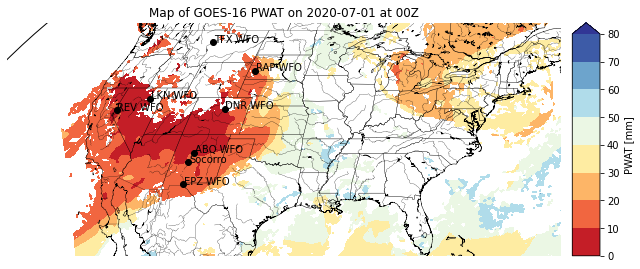

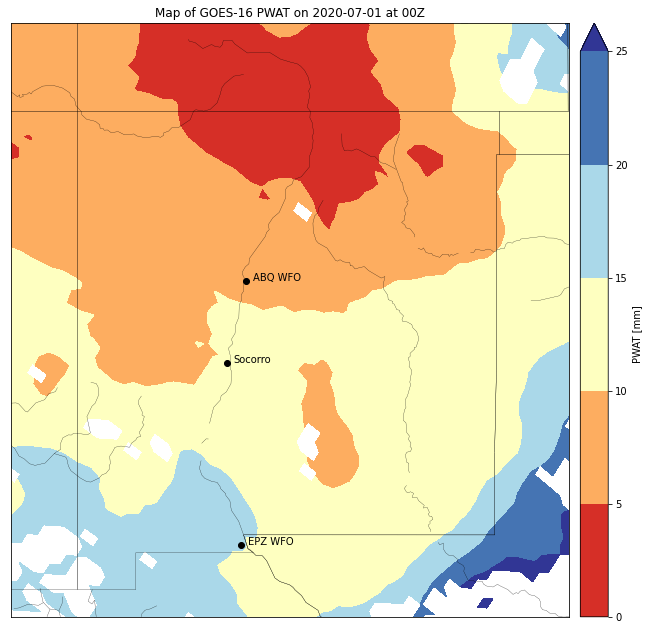

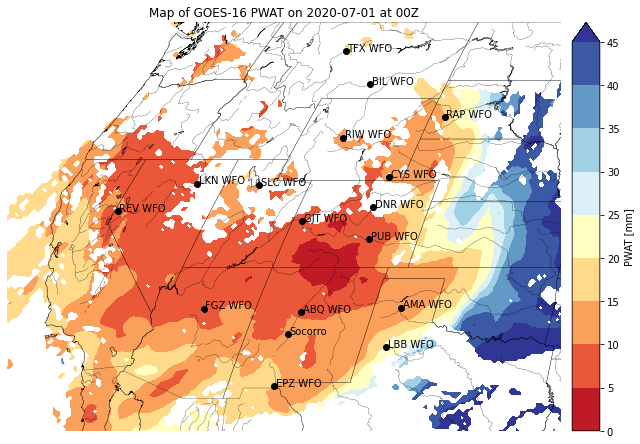

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


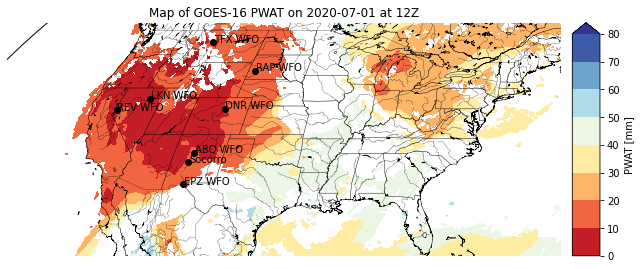

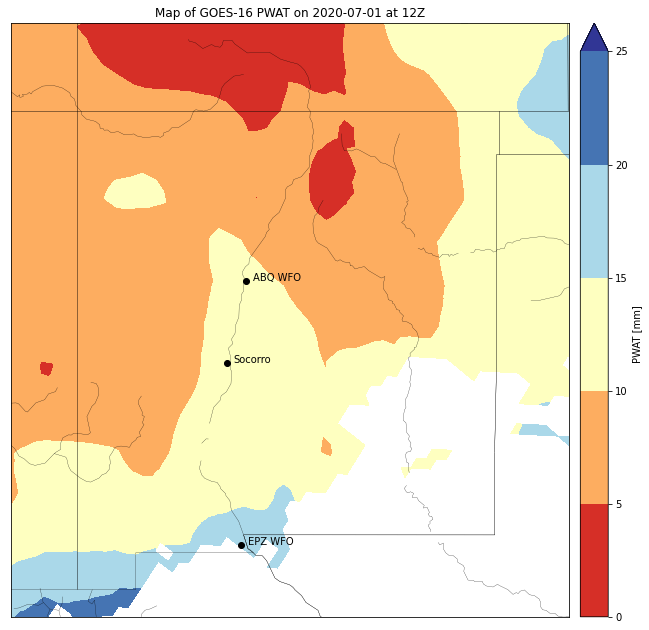

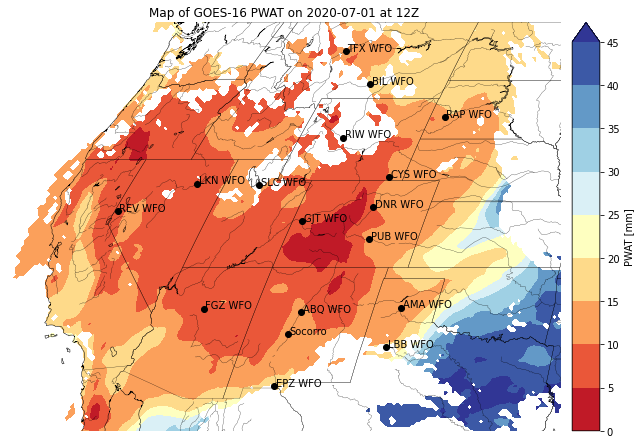

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


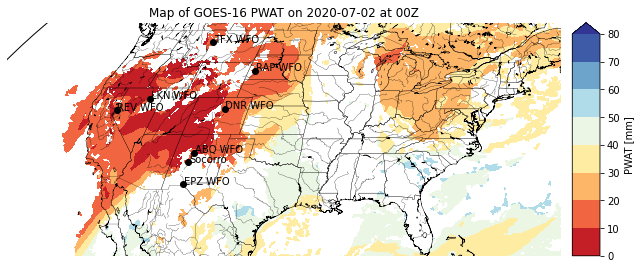

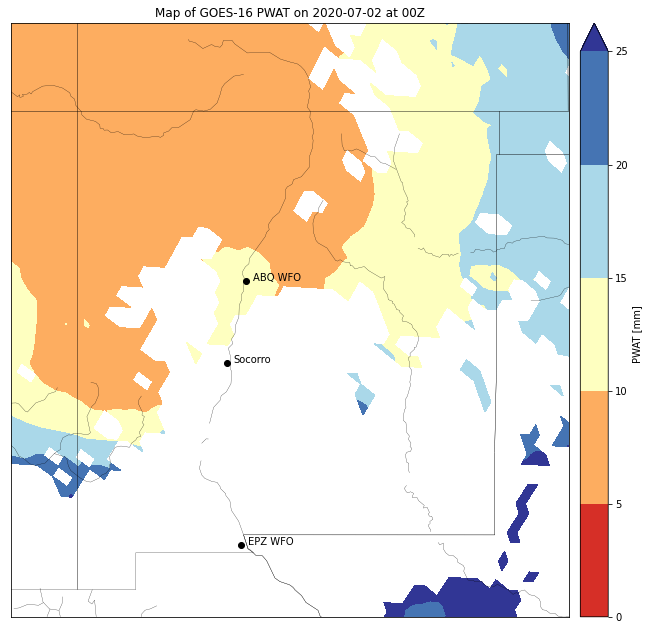

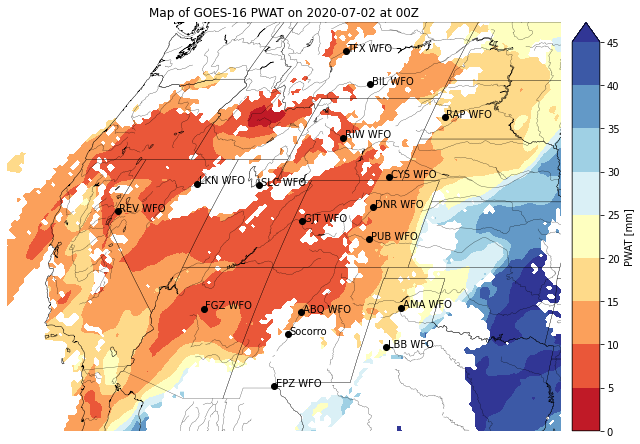

In [6]:
#result = {}  #no longer necessary here, but is below
for i in date_rng:
    objs = goes.objects.filter(
        Delimiter="/",
        Prefix="{product}/"
               "{year}/"
               "{daynum:03d}/"
               "{hour:02d}/".format(year=int(i.year),
                                    daynum=int(i.strftime("%j")),
                                    hour=int(i.hour),
                                    product='ABI-L2-TPWC'))
    result = {}
    try:
        dat_url = "https://noaa-goes16.s3.amazonaws.com/{object}#mode=bytes".format(object=list(objs)[0].key)
        with fsspec.open(dat_url) as fobj:
            data_goes = goes_pull(fobj)

            data = data_goes[0]
            lat = data_goes[1]
            lon = data_goes[2]

            result["Date"] = i.strftime("%Y-%m-%d %H:%M:%S")
            for j in tar_lst:
                result["NWS-{}".format(j)] = wyoming_import(i, j)
                result["G16-{}".format(j)] = goes_array(data_goes, target[j]["lon"], target[j]["lat"])


            df = pd.DataFrame.from_dict(result, orient="index").T

            if os.path.exists(fname):
                df.to_csv(fname,
                          sep="\t", mode="a",
                          index=False,
                          header=False)
            else:
                df.to_csv(fname,
                          sep="\t", mode="w",
                          index=False,
                          header=True)
# @sriley: You can use np.arange to get levels by an interval
# So, you can use np.linspace(start, end, num of levels)
# Or, you can use np.arange(start, end, interval)

#I'll probably use np.arange so I can get the levels that make the most sense
#You're right, target list is much easier to change than adding or deleting WFOs for different runs

            plt_map([-126, 25, -65 , 50],
                    data, lon, lat, conus_tar,
                    "conus", np.linspace(0, 80, 9), i, map_type)
            plt_map([-110, 31, -102, 38],
                    data, lon, lat, nm_tar,
                    "nm", np.arange(0, 30, 5), i, "merc")
            plt_map([-120, 30, -99, 49],
                    data, lon, lat, west_tar,
                    "west", np.arange(0, 50, 5), i, map_type)

    except IndexError:
        continue

gif_maps("conus")
gif_maps("west")
gif_maps("nm")

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


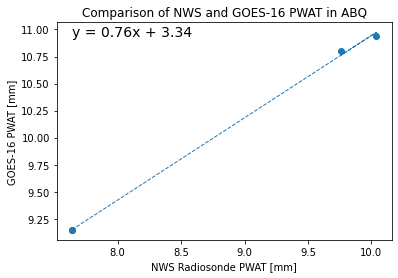

<Figure size 432x288 with 0 Axes>

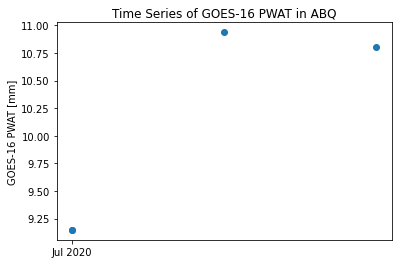

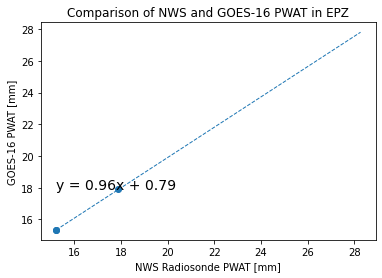

<Figure size 432x288 with 0 Axes>

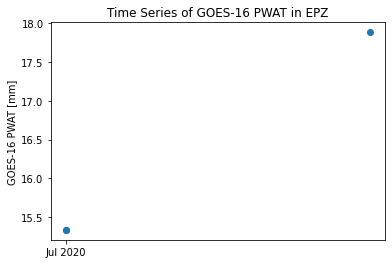

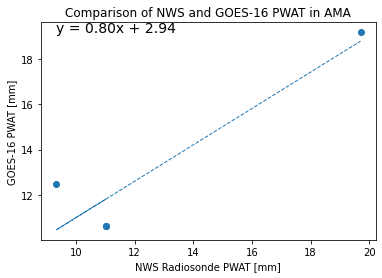

<Figure size 432x288 with 0 Axes>

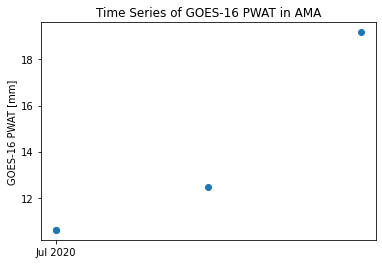

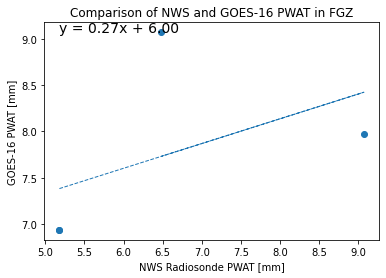

<Figure size 432x288 with 0 Axes>

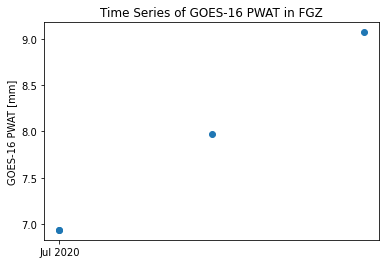

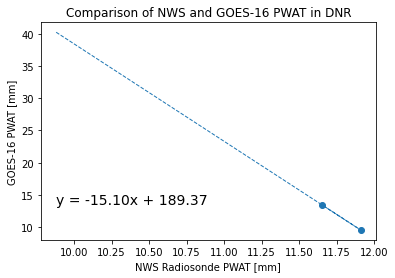

<Figure size 432x288 with 0 Axes>

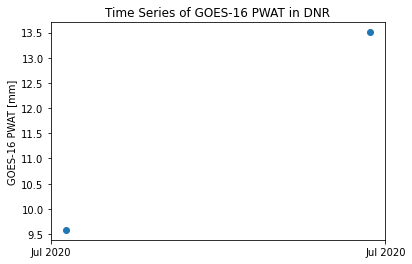

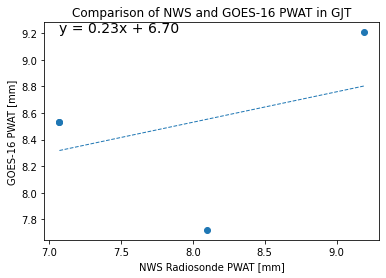

<Figure size 432x288 with 0 Axes>

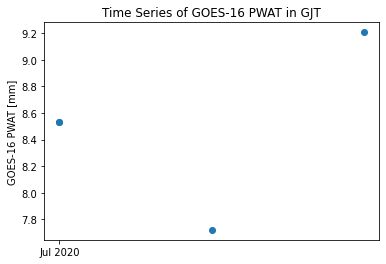

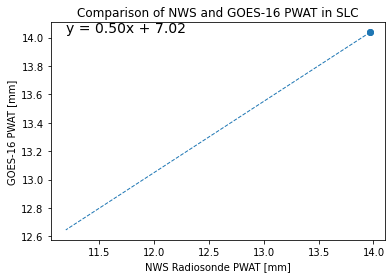

<Figure size 432x288 with 0 Axes>

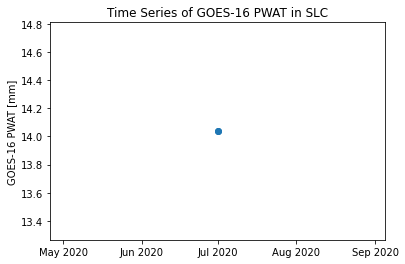

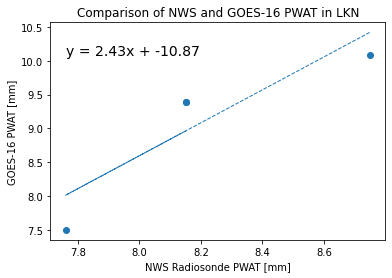

<Figure size 432x288 with 0 Axes>

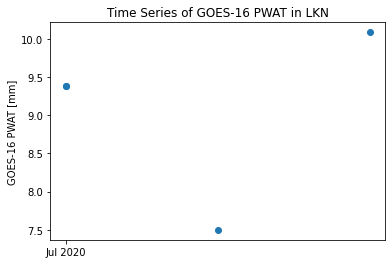

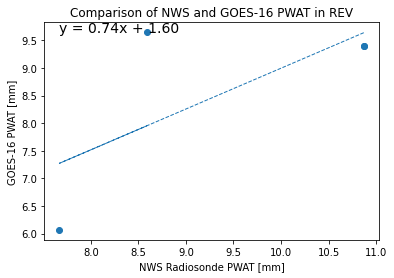

<Figure size 432x288 with 0 Axes>

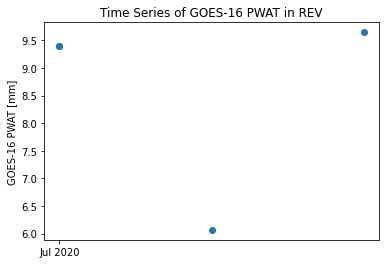

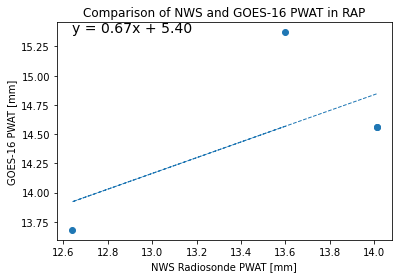

<Figure size 432x288 with 0 Axes>

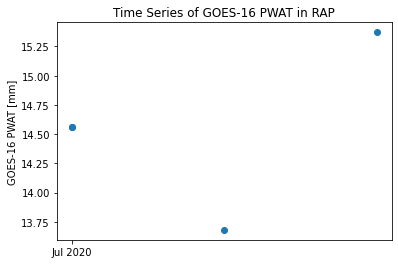

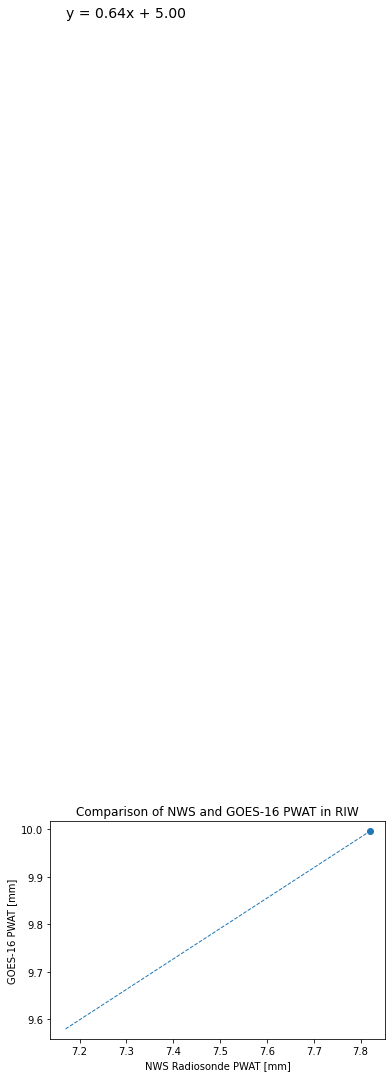

<Figure size 432x288 with 0 Axes>

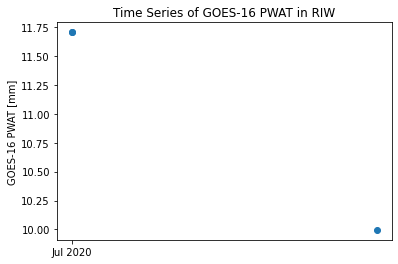

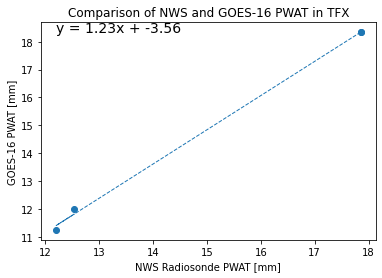

<Figure size 432x288 with 0 Axes>

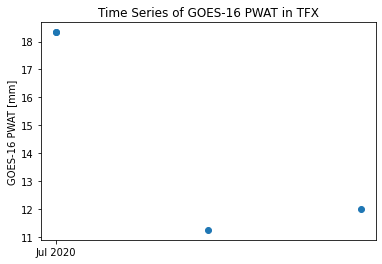

In [7]:
df = pd.read_csv(fname, sep="\t", header=0)

for j in tar_lst:
    plt.figure()
    plt.scatter(df["NWS-{}".format(j)], df["G16-{}".format(j)])
    idx = np.isfinite(df["NWS-{}".format(j)]) & np.isfinite(df["G16-{}".format(j)])
    a, b = np.polyfit(df["NWS-{}".format(j)][idx], df["G16-{}".format(j)][idx], 1)
    plt.plot(df["NWS-{}".format(j)], a*df["NWS-{}".format(j)] + b, linestyle='--', linewidth=1)
    plt.text(np.nanmin(df["NWS-{}".format(j)]), np.nanmax(df["G16-{}".format(j)]),
             "y = {:.2f}x + {:.2f}".format(a, b), size=14)
    plt.xlabel("NWS Radiosonde PWAT [mm]")
    plt.ylabel("GOES-16 PWAT [mm]")
    plt.title("Comparison of NWS and GOES-16 PWAT in {}".format(j))
    plt.savefig("./map/plots/plot_NWS_G16_{}.png".format(j))

    plt.figure()
    fig, ax = plt.subplots()
    ax.scatter(pd.to_datetime(df['Date']), df["G16-{}".format(j)])
    ax.set_ylabel("GOES-16 PWAT [mm]")
    ax.set_title("Time Series of GOES-16 PWAT in {}".format(j))
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))
    plt.savefig("./map/plots/time_G16_{}.png".format(j))

In [8]:
with fsspec.open(elname) as eobj:
    narr_data = xr.open_dataset(eobj)
    data_elv    = narr_data.variables['elevation']
    lat_elv     = narr_data.variables['latitude']
    lon_elv     = narr_data.variables['longitude']
    lon_elv, lat_elv = np.meshgrid(lon_elv, lat_elv)

    # @sriley: This works just like the GOES query from above. The units are in meters
    test_spot = goes_array([data_elv, lat_elv, lon_elv],
                           Socorro_lon,
                           Socorro_lat)
    elev_map([-126, 25, -65 , 50], lon_elv, lat_elv,
             np.arange(-500, 5000, 500), "merc")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/./GMTED2010_15n015_00625deg.nc'